In [1]:
import sys, copy

sys.path.append('..')

import decision_transformer.manage_obs as DT_manager
%matplotlib ipympl

/home/amir/freeflyer2/tr4ff/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


cpu


In [2]:
# Simulation configuration
transformer_model_name = 'checkpoint_ff_obs_ctgrtg'

In [3]:
# Import dataset and dataloader
datasets, dataloaders = DT_manager.get_train_val_test_data(mdp_constr=True, dataset_scenario='var_obstacles_4_scenarios', timestep_norm=False)

train_dataset, val_dataset, test_dataset = datasets
train_loader, eval_loader, test_loader = dataloaders


Loading data from root/dataset/torch/...Completed, DATA IS NOT SHUFFLED YET.



In [4]:
# Get the model and set it into eval mode
model = DT_manager.get_DT_model(transformer_model_name, train_loader, eval_loader, checkpoint_name='checkpoints_sum_after_embed')
model.eval();

GPT size: 11.1M parameters


RuntimeError: Error(s) in loading state_dict for AutonomousFreeflyerTransformer_VarObs:
	size mismatch for embed_observation.weight: copying a param with shape torch.Size([384, 12]) from checkpoint, the shape in current model is torch.Size([384, 3]).

In [8]:
# Sample from test dataloader
data_stats = test_loader.dataset.data_stats
test_sample = next(iter(test_loader))#test_loader.dataset.getix(39999)# <- deterministic sample OR random sample -> next(iter(test_loader))#

# data_stats = train_loader.dataset.data_stats
# # test_sample = next(iter(train_loader))#test_loader.dataset.getix(39999)# <- deterministic sample OR random sample -> next(iter(test_loader))#

states_i, observations_i, n_obs_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, time_discr_i, time_sec_i, ix_i = test_sample


# (states_i, observations_i, n_obs_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, dt,
#          time_sec, ix) = [item[0].unsqueeze(0) for item in test_sample]
# n_obs_i = [test_sample[2][0][0].unsqueeze(0)]

observations_i_temp = copy.deepcopy(observations_i[0] * data_stats['observations_std'] + data_stats['observations_mean'])

reshaped_observation = observations_i_temp[0, :3 * n_obs_i[0]].view(-1, 3)
obs_pos = reshaped_observation[:n_obs_i[0], :2]
obs_rad = reshaped_observation[:, 2]
obs = {
    'position': obs_pos.numpy(),
    'radius': obs_rad.numpy()
}

x_init = (states_i[0,0,:] * data_stats['states_std'][0]) + (data_stats['states_mean'][0])
x_final = (goal_i[0,0,:] * data_stats['goal_std'][0]) + (data_stats['goal_mean'][0])


In [9]:
# Use the model to perform offline RL
# Take the desired rtg0 from convex problem
from dynamics.freeflyer_obs import FreeflyerModel, ocp_no_obstacle_avoidance, ocp_obstacle_avoidance, np
ffm = FreeflyerModel(verbose=True)

traj, J, n_iter, status = ocp_no_obstacle_avoidance(ffm,x_init.cpu().numpy(),x_final.cpu().numpy(), copy.deepcopy(obs))
xs_no_obs_av = traj['states']
us_no_obs_av = traj['actions_G']

traj, J, n_iter, status = ocp_obstacle_avoidance(ffm, xs_no_obs_av, us_no_obs_av, x_init.cpu().numpy(),x_final.cpu().numpy(), copy.deepcopy(obs))
xs = traj['states']
us = traj['actions_G']

rtg_0 = -np.sum((np.linalg.norm(us_no_obs_av, ord=1, axis=0)))
# rtg_0 = -np.sum((np.linalg.norm(us, ord=1, axis=0)))

# rtg_0 = 1.1 * rtg_0

# rtg_0 = -.30

# Use the model (open-loop / dyn-in-the-loop)
ol_trajectory, runtime_DT = DT_manager.torch_model_inference_ol(model, test_loader, test_sample, rtg_perc=1., ctg_perc=0., rtg=rtg_0, ctg_clipped=True)
dyn_trajectory, runtime_DT = DT_manager.torch_model_inference_dyn(model, test_loader, test_sample, rtg_perc=1., ctg_perc=0., rtg=rtg_0, ctg_clipped=True)

Initializing freeflyer class.


In [10]:
rtg_0

-0.1699563755417839

tensor([[26825]])


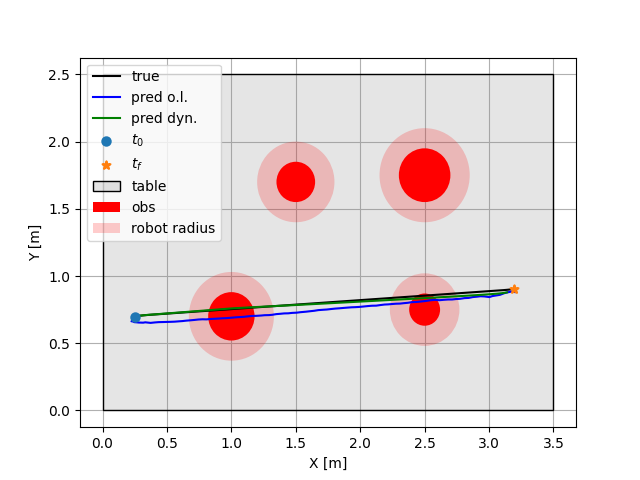

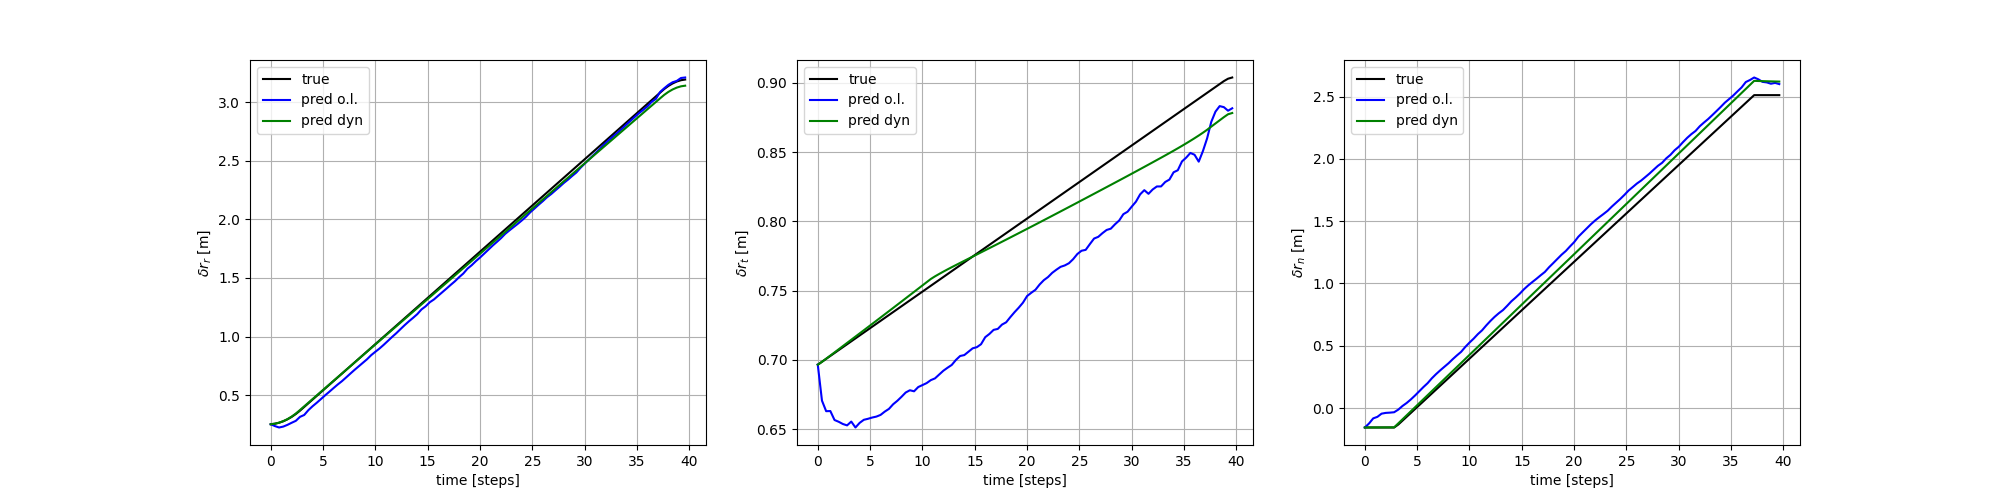

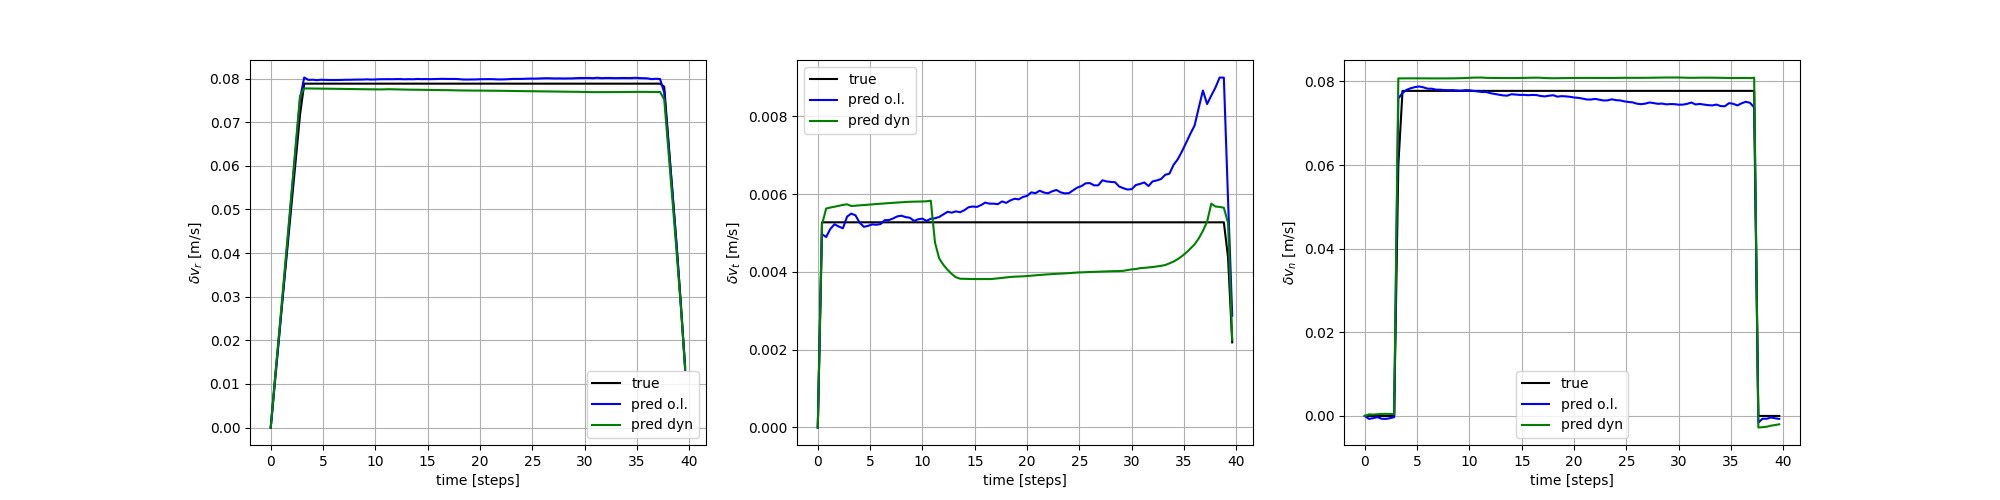

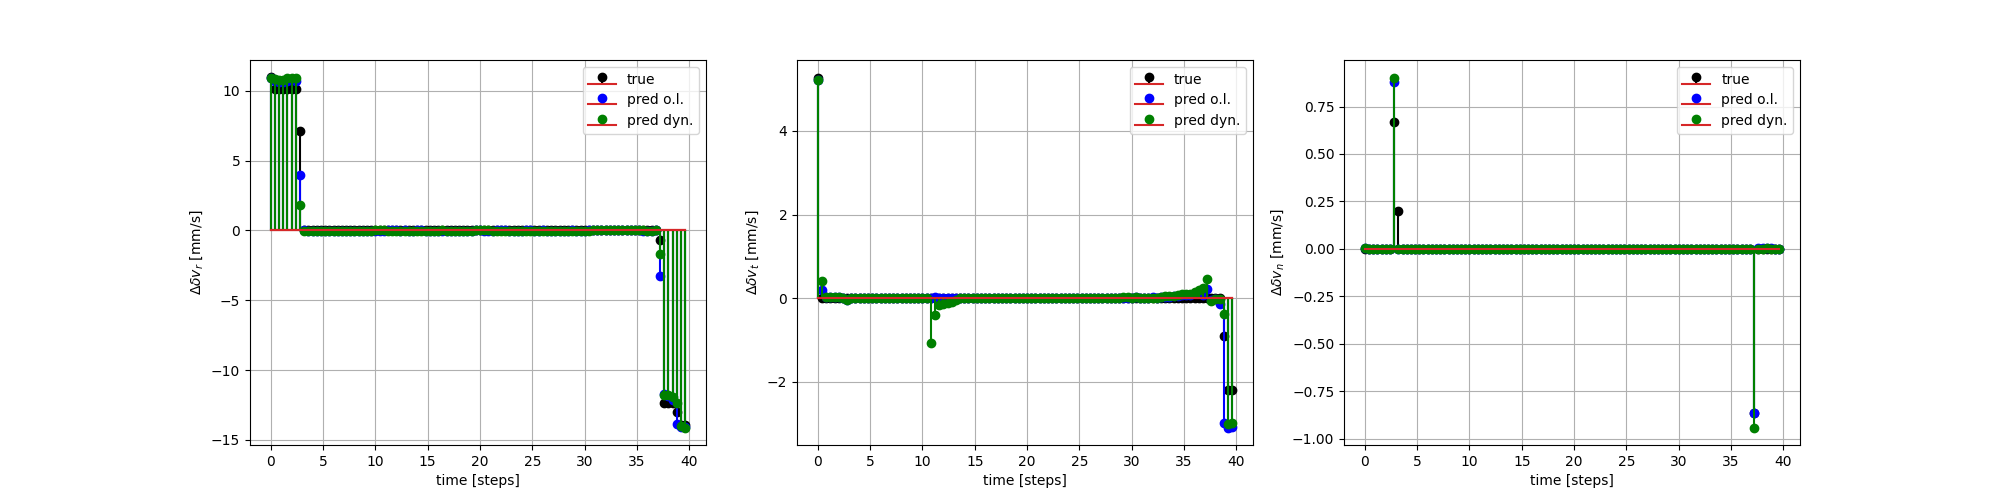

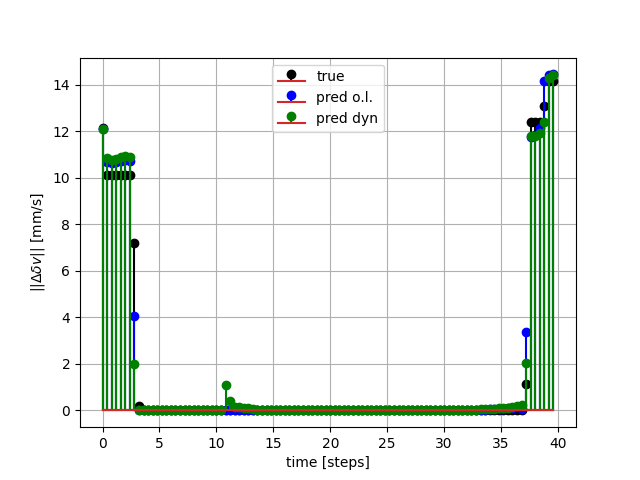

In [11]:
# Print the index of the trajectory and plot
DT_trajectory = {
    'xypsi_true' : ((states_i[0,:,:].cpu() * data_stats['states_std']) + data_stats['states_mean']).T,
    'xypsi_dyn' : dyn_trajectory['xypsi_dyn'],
    'xypsi_ol' : ol_trajectory['xypsi_ol'],
    'dv_true' : ((actions_i[0,:,:].cpu() * data_stats['actions_std']) + data_stats['actions_mean']).T,
    'dv_dyn' : dyn_trajectory['dv_dyn'],
    'dv_ol' : ol_trajectory['dv_ol'],
    'time' : ol_trajectory['time'],
    'obs': dyn_trajectory['obs']
}

# DT_trajectory = {
#     'xypsi_true' : traj['states'],
#     'xypsi_dyn' : dyn_trajectory['xypsi_dyn'],
#     'xypsi_ol' : ol_trajectory['xypsi_ol'],
#     'dv_true' : ((actions_i[0,:,:].cpu() * data_stats['actions_std']) + data_stats['actions_mean']).T,
#     'dv_dyn' : dyn_trajectory['dv_dyn'],
#     'dv_ol' : ol_trajectory['dv_ol'],
#     'time' : ol_trajectory['time'],
#     'obs': dyn_trajectory['obs']
# }


print(test_sample[-1])
DT_manager.plot_DT_trajectory(DT_trajectory)

In [ ]:
import decision_transformer.ros_manage as ros_TTO_manager

ros_model = ros_TTO_manager.get_only_DT_model(transformer_model_name, 6, 3)
data_stats = np.load('saved_files/data_stats.npz',allow_pickle=True)['data_stats'].item()
rosdyn_trajectory, rosruntime_DT = ros_TTO_manager.ros_model_inference_dyn(model, data_stats, x_init.cpu().numpy(), x_final.cpu().numpy(), rtg_perc=1., ctg_perc=0., rtg=rtg_0, ctg_clipped=True)

In [ ]:
DT_trajectory = {
    'xypsi_true' : ((states_i[0,:,:].cpu() * data_stats['states_std']) + data_stats['states_mean']).T,
    'xypsi_dyn' : rosdyn_trajectory['xypsi_dyn'],
    'xypsi_ol' : dyn_trajectory['xypsi_dyn'],
    'dv_true' : ((actions_i[0,:,:].cpu() * data_stats['actions_std']) + data_stats['actions_mean']).T,
    'dv_dyn' : rosdyn_trajectory['dv_dyn'],
    'dv_ol' : dyn_trajectory['dv_dyn'],
    'time' : dyn_trajectory['time']
}
print(test_sample[-1])
DT_manager.plot_DT_trajectory(DT_trajectory)

From this point onward -> experimental stuff

In [ ]:
from dynamics.freeflyer import *
x_init = np.array([-1.6807001 ,  0.74334077,  0.02128803, 0., 0., 0.])#-2, -0.20349702,  0.6+0.44711998,  0.       ,  0.       ,         0.])#
x_final = np.array([1.32320872, -0.70945767,  0.91129586, 0., 0., 0.])#1.5, 0.23441744,  0.6+0.56162705,  0.       ,  0.       ,         0.])#
qm = FreeflyerModel(verbose=True)
xs, us, J, status = ocp_no_obstacle_avoidance(qm,x_init,x_final,initial_guess='line')
xs, us, J, status, scp_iter = ocp_obstacle_avoidance(qm, xs, us, x_init, x_final)

In [ ]:
# Sample from test dataloader
data_stats = test_loader.dataset.data_stats
test_sample = test_loader.dataset.getix(39999)# <- deterministic sample OR random sample -> next(iter(test_loader))#
states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, time_discr_i, time_sec_i, ix_i = test_sample
x_init = (states_i[0,0,:] * data_stats['states_std'][0]) + (data_stats['states_mean'][0])
x_final = (goal_i[0,0,:] * data_stats['goal_std'][0]) + (data_stats['goal_mean'][0])
#x_init, x_final = sample_init_target()
'''test_sample[0][0,:,:] = (torch.tensor(np.repeat(x_init[None,:], 100, axis=0)) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#(torch.tensor(xs[:-1,:]) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#
test_sample[1][0,:,:] = torch.zeros((100,3))#(torch.tensor(us) - data_stats['actions_mean'])/(data_stats['actions_std'] + 1e-6)#
test_sample[2][0,:,0] = torch.zeros((100,))#torch.from_numpy(compute_reward_to_go(test_sample[1][0,:,:]))#
test_sample[3][:,0] = torch.zeros((100,))#torch.from_numpy(compute_constraint_to_go(test_sample[0][0,:,:].cpu().numpy(), obs_positions, obs_radii))#
test_sample[4][0,:,:] = (torch.tensor(np.repeat(x_final[None,:], 100, axis=0)) - data_stats['goal_mean'])/(data_stats['goal_std'] + 1e-6)'''
print(test_sample[-1])
DT_trajectory,_ = DT_manager.use_model_for_imitation_learning(model, train_loader, test_sample, ctg_perc=0., use_dynamics=True, output_attentions=True)

In [ ]:
model2 = DT_manager.get_DT_model('checkpoint_quad_random_forest_ctgrtg', train_loader, eval_loader)
model2.eval();
DT_trajectory2,_ = DT_manager.use_model_for_imitation_learning(model2, train_loader, test_sample, ctg_perc=1., use_dynamics=True, output_attentions=True)

In [ ]:
from dynamics.quadrotor import *
qm = QuadModel(verbose=True)
xs, us, J, status = ocp_no_obstacle_avoidance(qm,x_init,x_final,initial_guess='line')
rtg_0 = -np.sum((np.linalg.norm(us.T, axis=0))**2)/2
dyn_trajectory, runtime_DT = DT_manager.torch_model_inference_dyn(model, test_loader, test_sample, rtg_perc=1., ctg_perc=0., rtg=rtg_0, ctg_clipped=True)

In [ ]:
import matplotlib.pyplot as plt
k = 1
plt.figure()
plt.plot(dyn_trajectory['xyz_dyn'][k,:])
plt.plot(DT_trajectory['xyz_dyn'][k,:])
plt.show()

In [ ]:
# Print the index of the trajectory and plot
DT_trajectory['xyz_ol'] = dyn_trajectory['xyz_dyn']
DT_trajectory['dv_ol'] = dyn_trajectory['dv_dyn']
print(test_sample[-1])
DT_manager.plot_DT_trajectory(DT_trajectory)

In [ ]:
dist, viol = check_koz_constraint(dyn_trajectory['xyz_dyn'].T,obs_positions,obs_radii)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dist.T)
plt.plot([0, 100],[0, 0],'r-')
plt.xlabel('time')
plt.ylabel('distance from obstacles')
plt.show()

In [ ]:
states_ws_DT = np.append(dyn_trajectory['xyz_dyn'], (dyn_trajectory['xyz_dyn'][:,-1] + qm.f(dyn_trajectory['xyz_dyn'][:, -1], dyn_trajectory['dv_dyn'][:, -1])*dt).reshape((6,1)), 1).T
xs, us, J, status, scp_iter = ocp_obstacle_avoidance(qm, states_ws_DT, dyn_trajectory['dv_dyn'].T, x_init, x_final)

In [ ]:
xs2, us2, J, status = ocp_no_obstacle_avoidance(qm, x_init, x_final, initial_guess='keep')
print('-----------------')
xs2, us2, J, status, scp_iter = ocp_obstacle_avoidance(qm, xs2, us2, x_init, x_final)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10., azim=-20)

ax.scatter(x_init[0], x_init[1], x_init[2], color='k')
ax.scatter(x_final[0], x_final[1], x_final[2], color='k')
#ax.scatter(xs[8,0], xs[8,1], xs[8,2], color='k')

for i in range(n_obs):
    p = obs_positions[i]
    r = obs_radii[i]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = p[0] + r * np.outer(np.cos(u), np.sin(v))
    y = p[1] + r * np.outer(np.sin(u), np.sin(v))
    z = p[2] + r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3)
ax.plot3D(xs[:,0], xs[:,1], xs[:,2], color='b', linewidth=1)
ax.plot3D(xs2[:,0], xs2[:,1], xs2[:,2], color='g', linewidth=1)

plt.show()